In [1]:
%matplotlib inline
# !pip install python-Levenshtein
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer , IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
import numpy as np

In [2]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.iden(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

q = QuantumRegister(3, 'q')
circ = QuantumCircuit(q)
circ.h(0)
circ.h(1)
circ.h(2)
circ.cz(0,2)
circ.barrier(range(3))
circ.x(0)
circ.cx(0,2)
circ.rx(np.pi/2, 0)
circ.cx(1,2)
circ.swap(0,1)
circ.barrier(range(3))
circ.append(sub_inst, [q[1], q[2]])

circ.h(0)
circ.h(1)
circ.h(2)

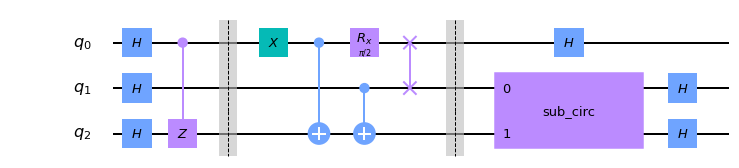

In [3]:
circ.draw()

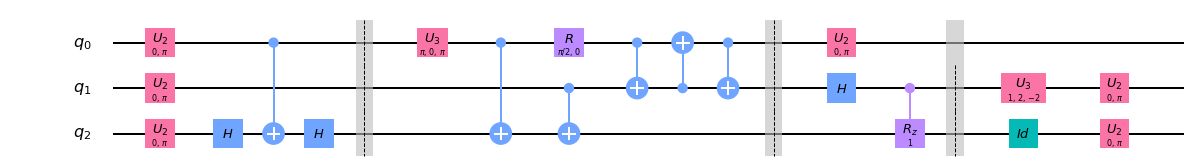

In [4]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw()

In [5]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)

In [6]:
result = job.result()
outputstate = result.get_statevector(circ, decimals=3)
print(outputstate)

[ 0.138-0.392j  0.181-0.077j  0.405-0.325j -0.029+0.134j -0.181+0.077j
  0.419+0.271j  0.029-0.134j -0.084-0.431j]


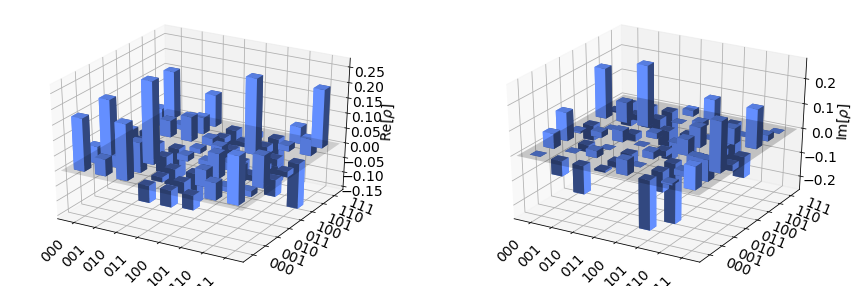

In [7]:
plot_state_city(outputstate)

In [8]:
meas = QuantumCircuit(3, 3)
meas.barrier(range(3))
meas.measure(range(3),range(3))

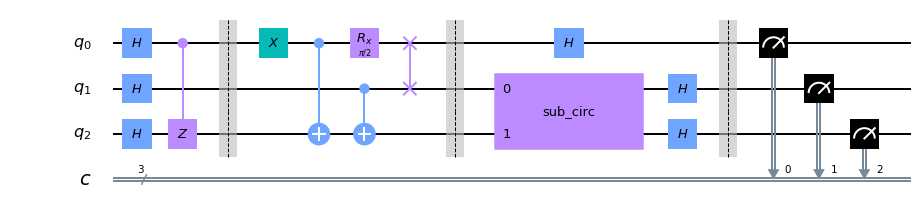

In [9]:
qc = circ+meas
qc.draw()

In [10]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim, shots=1024)

In [11]:
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

{'101': 237, '001': 30, '100': 32, '010': 282, '000': 192, '111': 216, '011': 15, '110': 20}


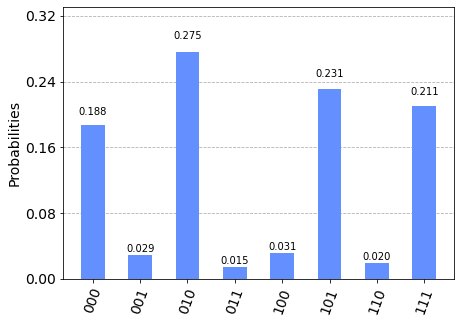

In [12]:
plot_histogram(counts)

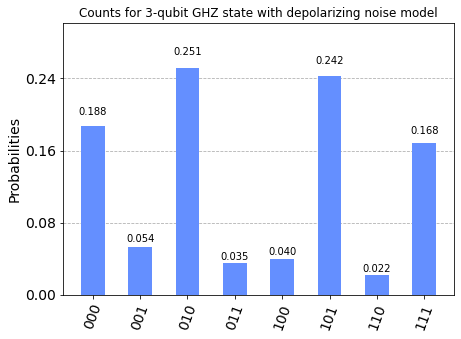

In [13]:
provider = IBMQ.load_account()
device_backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates
coupling_map = device_backend.configuration().coupling_map

result_noise = execute(qc, backend_sim, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(qc)
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")

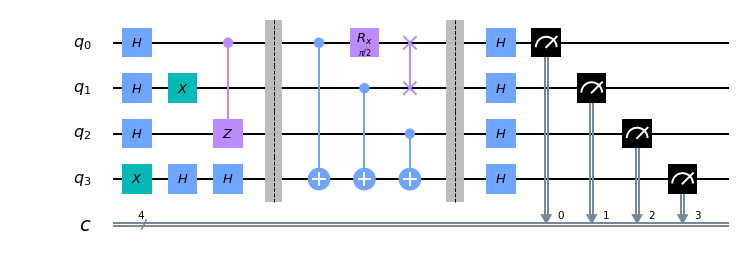

In [14]:
qarsmcirc = QuantumCircuit.from_qasm_str("""
OPENQASM 2.0; 
include "qelib1.inc"; 

qreg q[4];
creg c[4];

h q[0];
h q[1];
x q[1];
h q[2];
x q[3];
cz q[0],q[2];
h q[3];
h q[3];
barrier q[0];
barrier q[1];
barrier q[2];
barrier q[3];
cx q[0],q[3];
rx(pi/2) q[0];
cx q[1],q[3];
swap q[0],q[1];
cx q[2],q[3];
barrier q[0];
barrier q[1];
barrier q[2];
barrier q[3];
h q[0];
h q[1];
h q[2];
h q[3];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
""")
qarsmcirc.draw()

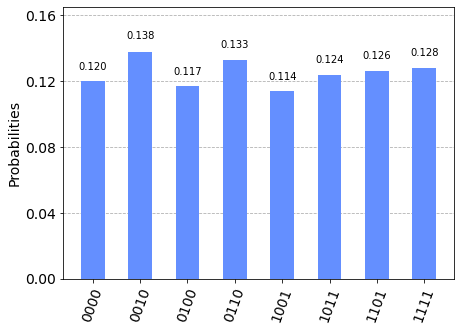

In [15]:
job_qasm = execute(qarsmcirc, backend_sim, shots=1024)
result_qasm = job_qasm.result()
counts = result_qasm.get_counts(qarsmcirc)
plot_histogram(counts)